# Import Packages and Define Helper Functions

In [181]:
# import necessary packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LassoCV, Lasso, lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

In [182]:
# Define helper functions we will use 
# Summarize confidence intervals for plotting
def summarize_ci(df, value_col, group_col):
    summary = []
    for group, group_df in df.groupby(group_col):
        stats = sms.DescrStatsW(group_df[value_col])
        mean, (ci_low, ci_high) = stats.mean, stats.tconfint_mean()
        summary.append({
            group_col: group,
            "Value": mean,
            "CI_Lower": ci_low,
            "CI_Upper": ci_high,
            "Count": len(group_df)
        })
    summary = pd.DataFrame(summary).sort_values(group_col)
    return summary

# Run a lasso regression that only select n significant features
def lasso_select_top_n(X, y, top_n, test_size=0.2, random_state=123, alpha_override=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if alpha_override is None:
        lasso_cv = LassoCV(cv=5, random_state=random_state, max_iter=10000)
        lasso_cv.fit(X_train_scaled, y_train)

        alphas, coefs, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)
        n_pred = (coefs != 0).sum(axis=0)
        closest_idx = np.abs(n_pred - top_n).argmin()
        alpha_target = alphas[closest_idx]
    else:
        alpha_target = alpha_override

    lasso_final = Lasso(alpha=alpha_target, max_iter=10000)
    lasso_final.fit(X_train_scaled, y_train)

    y_pred = lasso_final.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**.5

    coefs = pd.Series(lasso_final.coef_, index=X.columns)
    coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    return coefs, r2, rmse, alpha_target

# Plot binary shap values
def plot_shap_group_difference(shap_df, X_test, top_features, plot_title = "Groupwise Shap Differences", plot_color = 'black'):
    shap_df = shap_df.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    results = []

    for feat in top_features:
        group1 = shap_df[X_test[feat] == 1][feat]
        group0 = shap_df[X_test[feat] == 0][feat]

        d1 = sms.DescrStatsW(group1)
        d0 = sms.DescrStatsW(group0)

        diff = d1.mean - d0.mean
        ci_low, ci_upp = sms.CompareMeans(d1, d0).tconfint_diff()

        results.append((feat, diff, ci_low, ci_upp))

    results_dict = {feat: (mean_diff, ci_low, ci_high) for feat, mean_diff, ci_low, ci_high in results}
    ordered_results = [(feat, *results_dict[feat]) for feat in top_features]
    
    features, diffs, ci_lows, ci_upps = zip(*ordered_results)
    
    features = features[::-1]
    diffs = diffs[::-1]
    ci_lows = ci_lows[::-1]
    ci_upps = ci_upps[::-1]

    plt.figure(figsize=(8, 6))
    plt.errorbar(diffs, features, xerr=[np.array(diffs) - np.array(ci_lows),
                                        np.array(ci_upps) - np.array(diffs)],
                 fmt='o', color=plot_color, capsize=5)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(plot_title)
    plt.xlabel("Mean SHAP Difference (±95% CI)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Run XGBoost to extract feature importance with Shap
def xgb_cv(
    X, y, test_size=0.2, n_trials=50,
    n_splits=5, random_state=123,
    plot_title  = "Groupwise Shap Differences", plot_color = 'black'
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        }
        model = xgb.XGBRegressor(**params, random_state=random_state, verbosity=0)
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    print(f"Best Parameters:\n{best_params}")

    best_model = xgb.XGBRegressor(**best_params, random_state=random_state, verbosity=0)
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**.5
            
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", color = plot_color, max_display=10)

    shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
    shap_mean_abs = shap_df.abs().mean().sort_values(ascending=False)
    top_features = shap_mean_abs.head(10).index.tolist()
    
    plot_shap_group_difference(shap_df, X_test, top_features, plot_title, plot_color)

    print(f"Percent of the Variance of {y.name} Explained: {r2:.3f}")

    return best_model, best_params, r2, rmse

# Bootstrap helper for soft-weighted averages
def bootstrap_soft_averages(W, target_array, n_boot=1000):
    boot_means = np.zeros((n_boot, W.shape[1]))
    for b in range(n_boot):
        idx = np.random.choice(W.shape[0], size=W.shape[0], replace=True)
        W_boot = W[idx]
        t_boot = target_array[idx]
        boot_means[b] = (W_boot.T @ t_boot) / W_boot.sum(axis=0)
    return boot_means

# Load and Inspect Data

In [183]:
games = pd.read_csv("games.csv")

print(games.info())
print(games.isnull().sum())
print(f"Duplicate BGGIds: {games.duplicated('BGGId').sum()}")
games.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BGGId                21925 non-null  int64  
 1   Name                 21925 non-null  object 
 2   Description          21924 non-null  object 
 3   YearPublished        21925 non-null  int64  
 4   GameWeight           21925 non-null  float64
 5   AvgRating            21925 non-null  float64
 6   BayesAvgRating       21925 non-null  float64
 7   StdDev               21925 non-null  float64
 8   MinPlayers           21925 non-null  int64  
 9   MaxPlayers           21925 non-null  int64  
 10  ComAgeRec            16395 non-null  float64
 11  LanguageEase         16034 non-null  float64
 12  BestPlayers          21925 non-null  int64  
 13  GoodPlayers          21925 non-null  object 
 14  NumOwned             21925 non-null  int64  
 15  NumWant              21925 non-null 

(21925, 48)

# Clean Data

## Remove unrated games

Distribution of Number of ratings

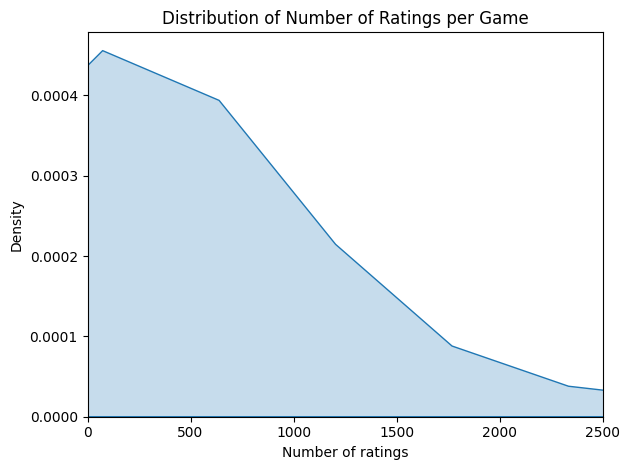

In [184]:
plt.figure()
sns.kdeplot(games['NumUserRatings'], fill=True, bw_adjust=1.5)
plt.title("Distribution of Number of Ratings per Game")
plt.xlim(0, 2500)
plt.xlabel("Number of ratings")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


Lets zoom in.

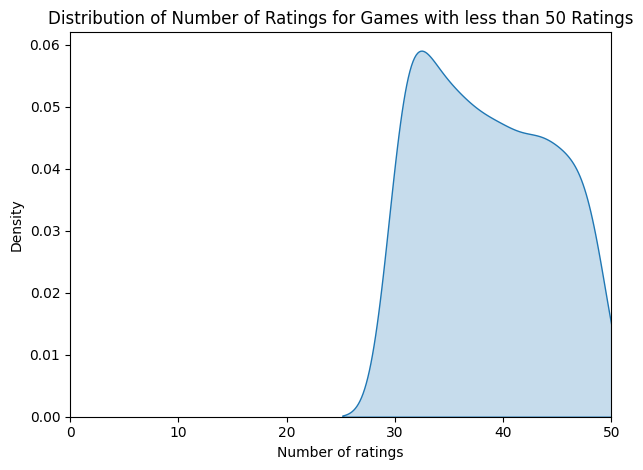

In [185]:
plt.figure()
sns.kdeplot(games.loc[games['NumUserRatings'] < 50,'NumUserRatings'], fill=True, bw_adjust=1.5)
plt.title("Distribution of Number of Ratings for Games with less than 50 Ratings")
plt.xlim(0, 50)
plt.xlabel("Number of ratings")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


A number of games have less than 30 ratings. Since games with only a handful of ratings may not reliably reflect popular opinion, we will exclude these.


In [186]:
games = games[games['NumUserRatings'] > 30]
games.shape

(21647, 48)

## Remove Unowned Games
Next, since it is a key variable of interest, we will exclude games that no one owns.

In [187]:
games[games['NumOwned'] == 0]


,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
21444,315727,Last Light,light fastpaced x game d planet rotate board p...,0,3.0,8.49991,5.55399,0.778145,1,4,...,21926,21926,0,0,0,0,0,0,0,0


In [188]:
games = games[games['NumOwned'] != 0]

## Remove Games before the Modern Era
Lastly, to keep our analyses relevant to a modern context, we will restrict our analyses to games published after 1900.

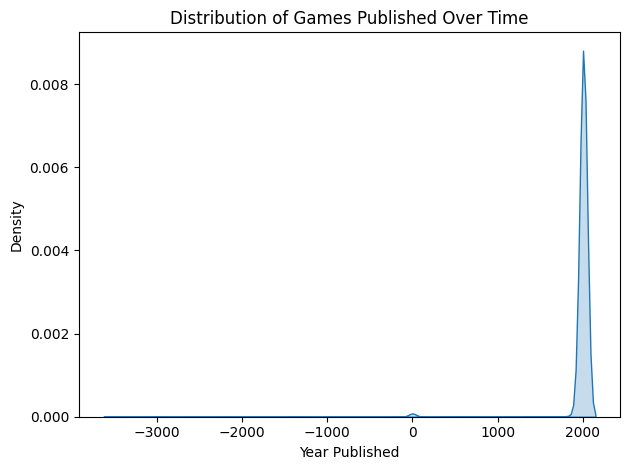

In [189]:
year = games["YearPublished"]
plt.figure()
sns.kdeplot(year, fill=True, bw_adjust=1.5)
plt.title("Distribution of Games Published Over Time")
plt.xlabel("Year Published")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

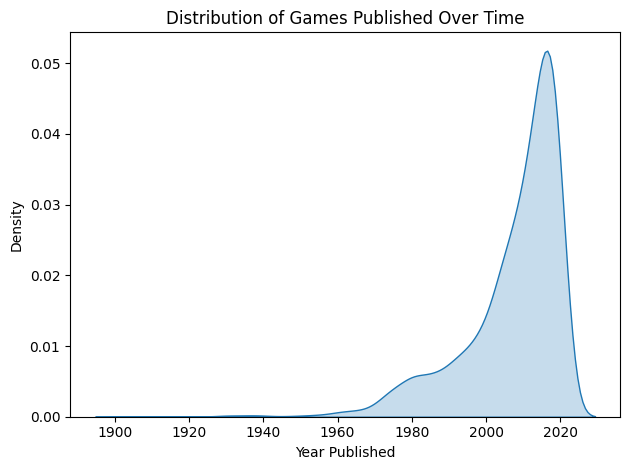

In [190]:
year_1900 = games.loc[games['YearPublished'] > 1900,"YearPublished"]
plt.figure()
sns.kdeplot(year_1900, fill=True, bw_adjust=1.5)
plt.title("Distribution of Games Published Over Time")
plt.xlabel("Year Published")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [191]:
games = games[games['YearPublished'] > 1900]
games.shape

(21341, 48)

# Descriptive Analyses
## What is the Distribution of Average Ratings across Board Games?

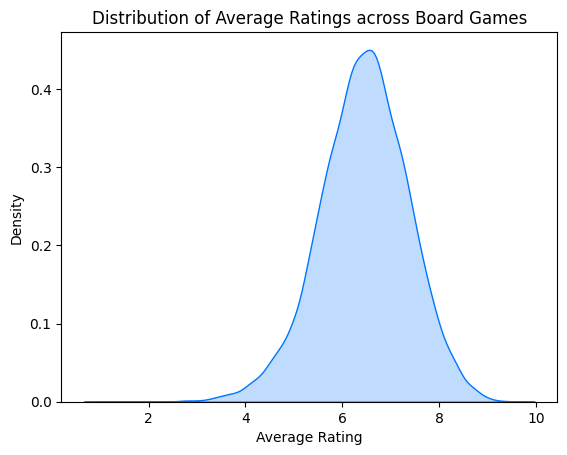

AvgRating    6.43692
dtype: float64


In [192]:
plt.figure()
sns.kdeplot(games["AvgRating"], fill=True, color = '#0074ff')
plt.xlabel("Average Rating")
plt.title("Distribution of Average Ratings across Board Games")
plt.show()
print(games[["AvgRating"]].mean())



## What is the Distribution of Games Owned across Board Games?

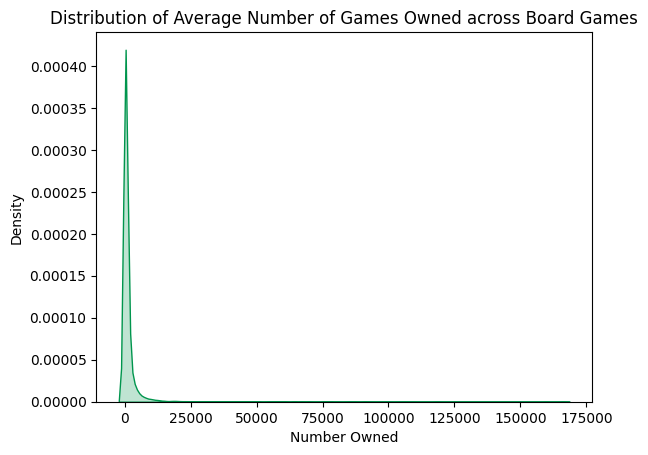

NumOwned    1492.598566
dtype: float64

In [193]:
plt.figure()
sns.kdeplot(games["NumOwned"], fill=True, color="#00954d")
plt.xlabel("Number Owned")
plt.title("Distribution of Average Number of Games Owned across Board Games")
plt.show()
games[["NumOwned"]].mean()

## Log Transform Number of Games Owned

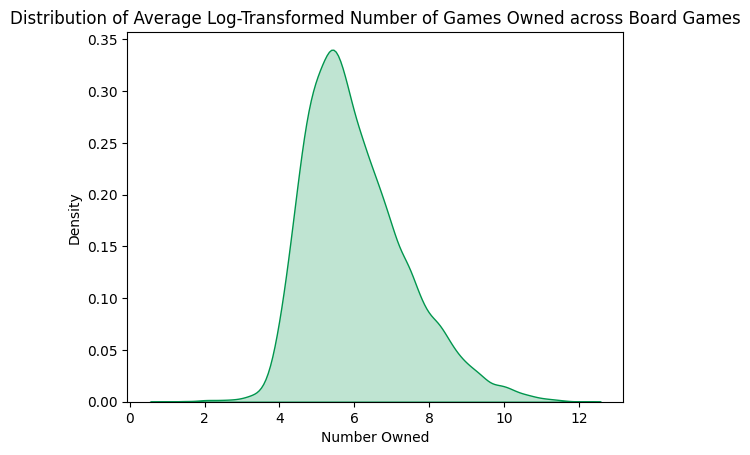

NumOwned_Log    6.044753
dtype: float64

In [194]:
games['NumOwned_Log'] = np.log1p(games['NumOwned'])
sns.kdeplot(games["NumOwned_Log"], fill=True, color="#00954d")
plt.xlabel("Number Owned")
plt.title("Distribution of Average Log-Transformed Number of Games Owned across Board Games")
plt.show()
games[["NumOwned_Log"]].mean()

## Have Ratings and Ownership of Board Games Increased with Time?

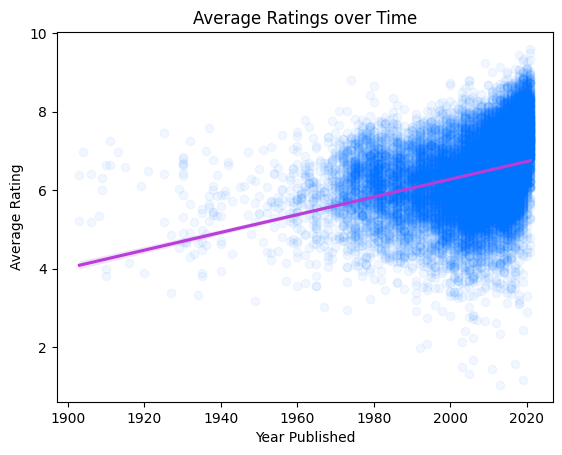

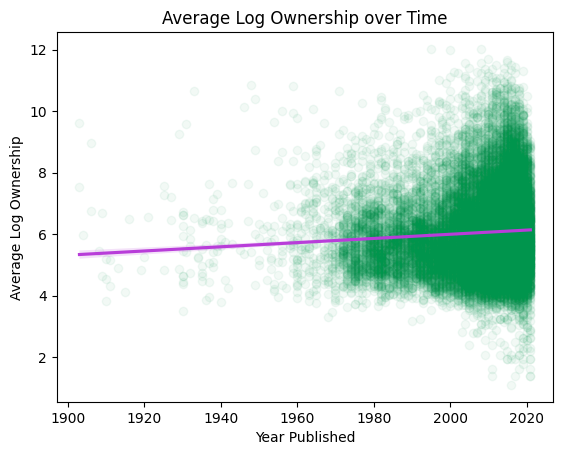

In [195]:
plt.figure()
sns.regplot(
    data=games,
    x="YearPublished",
    y="AvgRating",
    color = '#0074ff',
    scatter_kws={"alpha": 0.05},
    line_kws={"color": "#b83dd9"},
)
plt.xlabel("Year Published")
plt.ylabel("Average Rating")
plt.title("Average Ratings over Time")
plt.show()

plt.figure()
sns.regplot(
    data=games,
    x="YearPublished",
    y="NumOwned_Log",
    color = "#00954d",
    scatter_kws={"alpha": 0.05},
    line_kws={"color": "#b83dd9"},
)
plt.xlabel("Year Published")
plt.ylabel("Average Log Ownership")
plt.title("Average Log Ownership over Time")
plt.show()



## Do Kickstarter Games Correlate to Higher Ratings? 

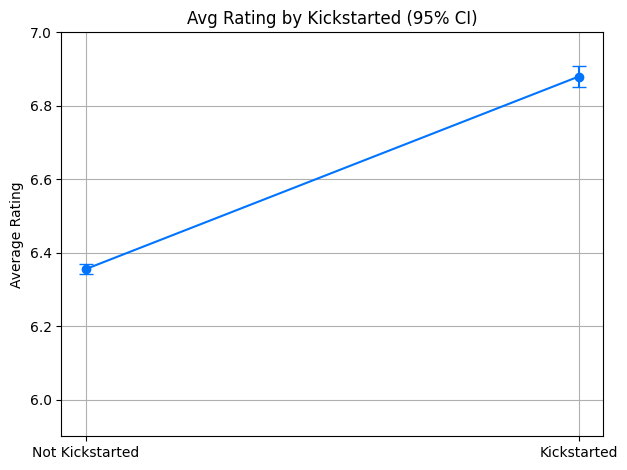

AvgRating: Mean difference = 0.524, t = 32.158, p = 1.06e-205


In [196]:
rating_summary = summarize_ci(games, value_col="AvgRating", group_col="Kickstarted")

plt.errorbar(
    rating_summary["Kickstarted"],
    rating_summary["Value"],
    color = '#0074ff',
    yerr=[
        rating_summary["Value"] - rating_summary["CI_Lower"],
        rating_summary["CI_Upper"] - rating_summary["Value"]
    ],
    fmt="o-", capsize=5
)
plt.xticks([0, 1], ["Not Kickstarted", "Kickstarted"])
plt.ylabel("Average Rating")
plt.title("Avg Rating by Kickstarted (95% CI)")
plt.grid(True)
plt.tight_layout()
plt.ylim(5.9,7)
plt.show()

kick = games[games["Kickstarted"] == 1]
not_kick = games[games["Kickstarted"] == 0]

t_rating, p_rating = ttest_ind(kick["AvgRating"], not_kick["AvgRating"], equal_var=False)

mean_diff_rating = rating_summary.loc[rating_summary["Kickstarted"] == 1, "Value"].values[0] - rating_summary.loc[rating_summary["Kickstarted"] == 0, "Value"].values[0]

print(f"AvgRating: Mean difference = {mean_diff_rating:.3f}, t = {t_rating:.3f}, p = {p_rating:.3g}")

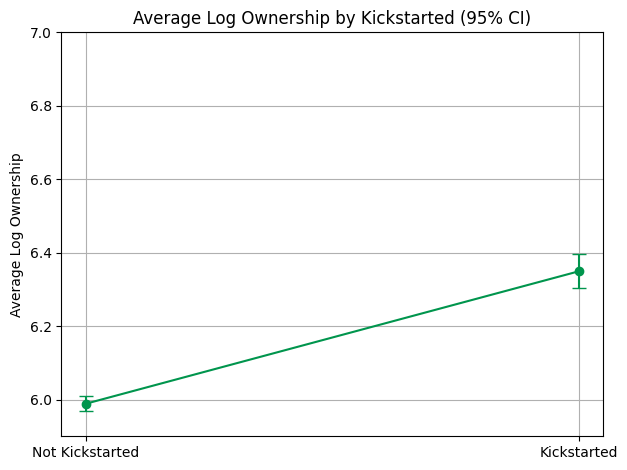

Log Ownership: Mean difference = 0.360, t = 13.988, p = 1.43e-43


In [197]:
owned_summary = summarize_ci(games, value_col="NumOwned_Log", group_col="Kickstarted")

plt.errorbar(
    owned_summary["Kickstarted"],
    owned_summary["Value"],
    color = "#00954d",
    yerr=[
        owned_summary["Value"] - owned_summary["CI_Lower"],
        owned_summary["CI_Upper"] - owned_summary["Value"]
    ],
    fmt="o-", capsize=5
)
plt.xticks([0, 1], ["Not Kickstarted", "Kickstarted"])
plt.ylabel("Average Log Ownership")
plt.title("Average Log Ownership by Kickstarted (95% CI)")
plt.grid(True)
plt.ylim(5.9,7)
plt.tight_layout()
plt.show()

t_owned, p_owned = ttest_ind(kick["NumOwned_Log"], not_kick["NumOwned_Log"], equal_var=False)
mean_diff_owned = owned_summary.loc[owned_summary["Kickstarted"] == 1, "Value"].values[0] - owned_summary.loc[owned_summary["Kickstarted"] == 0, "Value"].values[0]
print(f"Log Ownership: Mean difference = {mean_diff_owned:.3f}, t = {t_owned:.3f}, p = {p_owned:.3g}")

## What Number of Players do People Prefer in a Game?

When missing, impute best number of players from average between min and max players.

In [198]:
players = games[["Name", "AvgRating", "NumOwned_Log", "BestPlayers", "MinPlayers", "MaxPlayers"]]
players = players[(players["MaxPlayers"] > 0) & (players["MinPlayers"] > 0)]
players["BestPlayers"] = players["BestPlayers"].replace(0, np.nan)
players["AvgPlayers"] = (players["MinPlayers"] + players["MaxPlayers"]) / 2
players["BestPlayers"].fillna(players["AvgPlayers"].round(), inplace=True)
players = players[players['BestPlayers'] < 11]

C:\Users\natha\AppData\Local\Temp\ipykernel_30304\4083726553.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  players["BestPlayers"].fillna(players["AvgPlayers"].round(), inplace=True)


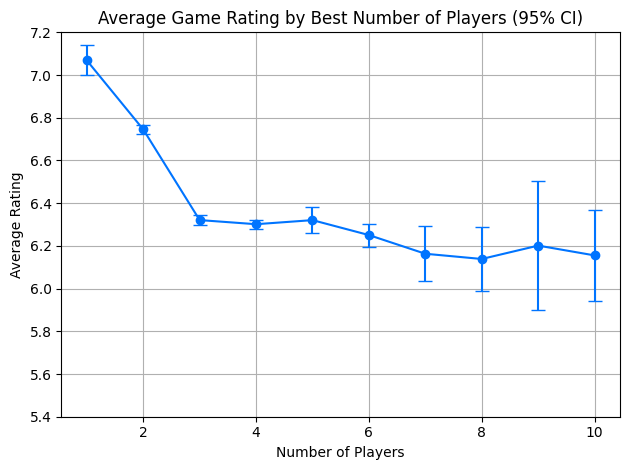

             AvgRating  BestPlayers
AvgRating     1.000000    -0.186954
BestPlayers  -0.186954     1.000000


In [199]:
players_summary = summarize_ci(players,'AvgRating','BestPlayers')

plt.errorbar(
    players_summary["BestPlayers"],
    players_summary["Value"],
    color = '#0074ff',
    yerr=[
        players_summary["Value"] - players_summary["CI_Lower"],
        players_summary["CI_Upper"] - players_summary["Value"]
    ],
    fmt="o-", capsize=5
)
plt.title("Average Game Rating by Best Number of Players (95% CI)")
plt.xlabel("Number of Players")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.ylim(5.4,7.2)
plt.show()

print(players[["AvgRating", "BestPlayers"]][players["BestPlayers"] < 11].corr())

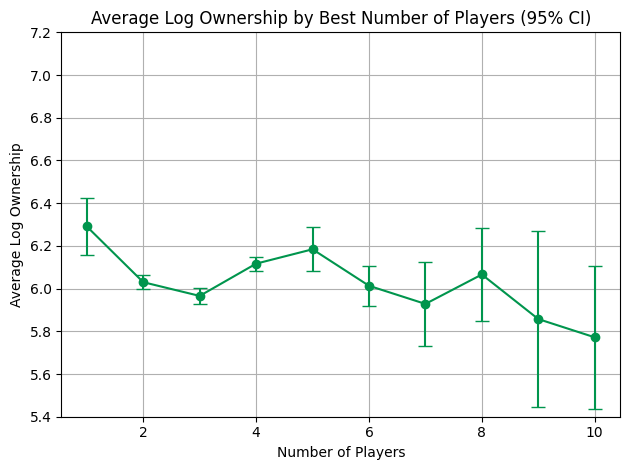

             AvgRating  BestPlayers
AvgRating     1.000000    -0.186954
BestPlayers  -0.186954     1.000000


In [200]:
players_summary = summarize_ci(players,'NumOwned_Log','BestPlayers')
players_summary = players_summary[players_summary["BestPlayers"] < 11]

plt.errorbar(
    players_summary["BestPlayers"],
    players_summary["Value"],
    color = "#00954d",
    yerr=[
        players_summary["Value"] - players_summary["CI_Lower"],
        players_summary["CI_Upper"] - players_summary["Value"]
    ],
    fmt="o-", capsize=5
)
plt.title("Average Log Ownership by Best Number of Players (95% CI)")
plt.xlabel("Number of Players")
plt.ylabel("Average Log Ownership")
plt.grid(True)
plt.tight_layout()
plt.ylim(5.4,7.2)
plt.show()

print(players[["AvgRating", "BestPlayers"]][players["BestPlayers"] < 11].corr())

## What are the Best and Worst Categories of Games?

In [201]:
cat_cols = [col for col in games.columns if col.startswith("Cat:")]

cat_df = games[["Name", "BGGId", "AvgRating", "NumOwned_Log"] + cat_cols].copy()
cat_df.set_index("Name",inplace=True)
cat_long = cat_df.melt(
    id_vars=["BGGId", "AvgRating", "NumOwned_Log"],
    value_vars=cat_cols,
    var_name="Category",
    value_name="Included"
)

cat_long = cat_long[cat_long["Included"] == 1]
cat_long["Category"] = cat_long["Category"].str.replace("Cat:", "", regex=False)

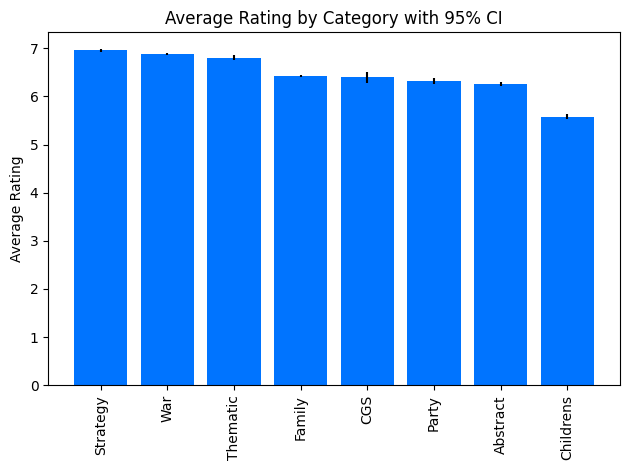

In [202]:
# Summarize AvgRating
rating_summary = summarize_ci(cat_long, "AvgRating", "Category")
rating_summary = rating_summary.sort_values("Value", ascending=False)

# Plot AvgRating
plt.figure()
plt.bar(
    rating_summary["Category"],
    rating_summary["Value"],
    color = '#0074ff',
    yerr=[
        rating_summary["Value"] - rating_summary["CI_Lower"],
        rating_summary["CI_Upper"] - rating_summary["Value"]
    ],
)
plt.xticks(rotation=90)
plt.title("Average Rating by Category with 95% CI")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

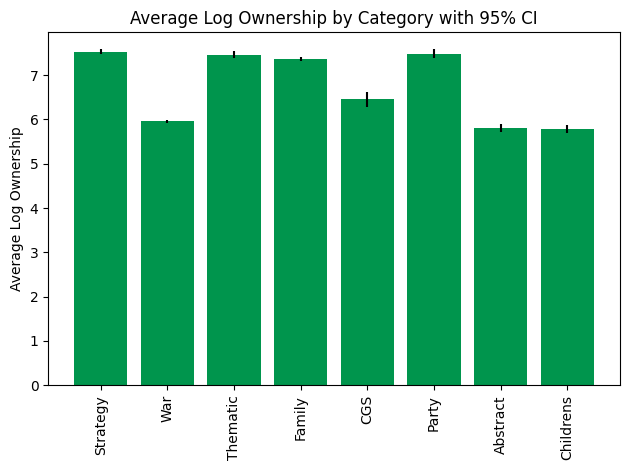

In [203]:
# Summarize NumOwned
owned_summary = summarize_ci(cat_long, "NumOwned_Log", "Category")
owned_summary = owned_summary.set_index("Category").loc[rating_summary["Category"].tolist()].reset_index()

# Plot NumOwned
plt.figure()
plt.bar(
    owned_summary["Category"],
    owned_summary["Value"],
    color = "#00954d",
    yerr=[
        owned_summary["Value"] - owned_summary["CI_Lower"],
        owned_summary["CI_Upper"] - owned_summary["Value"]
    ]
)
plt.xticks(rotation=90)
plt.title("Average Log Ownership by Category with 95% CI")
plt.ylabel("Average Log Ownership")
plt.tight_layout()
plt.show()

## Most Important Themes in a Game?

### Load and Inspect Theme data

In [204]:
themes = pd.read_csv("themes.csv")

print(themes.info())
print(themes.isnull().sum())
print(f"Duplicate BGGIds: {themes.duplicated('BGGId').sum()}")
themes.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Columns: 218 entries, BGGId to Theme_Flags identification
dtypes: int64(218)
memory usage: 36.5 MB
None
BGGId                          0
Adventure                      0
Fantasy                        0
Fighting                       0
Environmental                  0
                              ..
Theme_French Foreign Legion    0
Theme_Cruise ships             0
Theme_Apache Tribes            0
Theme_Rivers                   0
Theme_Flags identification     0
Length: 218, dtype: int64
Duplicate BGGIds: 0


(21925, 218)

### Restructure Data

In [205]:
themes_df = games[["Name", "BGGId", "NumOwned_Log", "AvgRating"]].merge(themes, on="BGGId")
themes_df.set_index("Name", inplace=True)

### Most Predictive Themes of Game Rating

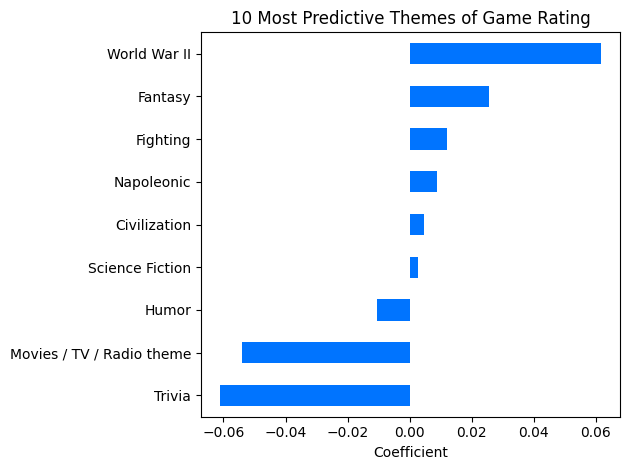

0.04714554346169131 Percent of the Variance of Game Rating explained


In [206]:
X = themes_df.drop(columns=["BGGId", "AvgRating", "NumOwned_Log"]).astype(float)
y = themes_df['AvgRating']
coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)
plt.figure()
coefs.sort_values().plot(kind="barh", color = '#0074ff')
plt.title('10 Most Predictive Themes of Game Rating')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Rating explained")

### Most Predictive Themes of Game Ownership

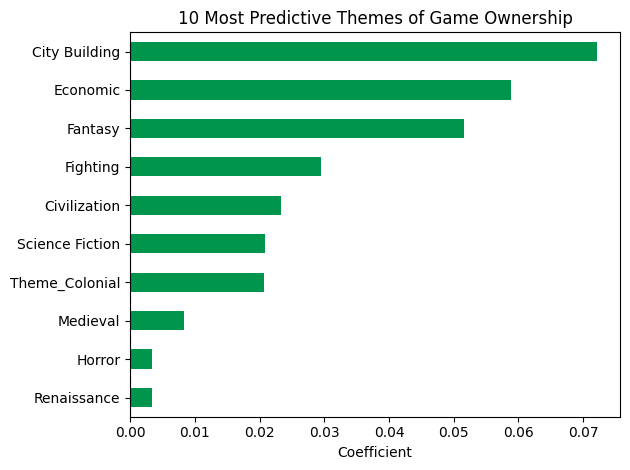

0.030190821333185625 Percent of the Variance of Game Ownership explained


In [207]:
y = themes_df['NumOwned_Log']
coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)

plt.figure()
coefs.sort_values().plot(kind="barh", color = "#00954d")
plt.title('10 Most Predictive Themes of Game Ownership')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Ownership explained")

## Most Important Game Mechanics

### Load and Inspect Mechanic Data

In [208]:
mechanics = pd.read_csv("mechanics.csv")

print(mechanics .info())
print(mechanics .isnull().sum())
print(f"Duplicate BGGIds: {mechanics .duplicated('BGGId').sum()}")
mechanics.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Columns: 158 entries, BGGId to Physical
dtypes: int64(158)
memory usage: 26.4 MB
None
BGGId                        0
Alliances                    0
Area Majority / Influence    0
Auction/Bidding              0
Dice Rolling                 0
                            ..
Rondel                       0
Automatic Resource Growth    0
Legacy Game                  0
Dexterity                    0
Physical                     0
Length: 158, dtype: int64
Duplicate BGGIds: 0


(21925, 158)

### Restructure Data

In [209]:
mechanics_df = games[["Name", "BGGId", "NumOwned_Log", "AvgRating"]].merge(mechanics, on="BGGId")
mechanics_df.set_index("Name", inplace=True)

### Most Predictive Mechanics of Game Rating

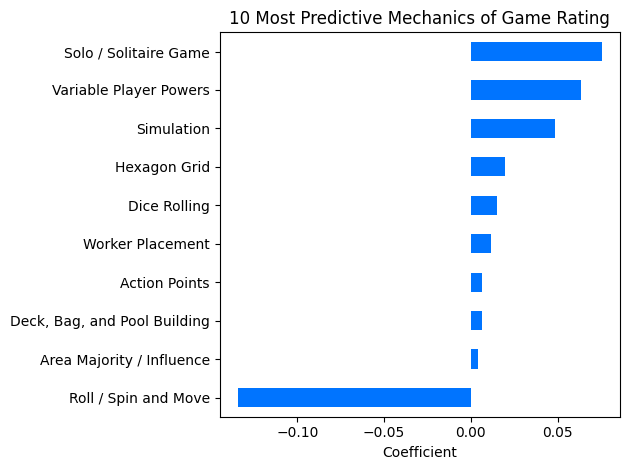

0.1292040574631098 Percent of the Variance of Game Rating explained


In [210]:
X = mechanics_df.drop(columns=["BGGId", "AvgRating", "NumOwned_Log"]).astype(float)
y = mechanics_df['AvgRating']
coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)

plt.figure()
coefs.sort_values().plot(kind="barh", color = '#0074ff')
plt.title('10 Most Predictive Mechanics of Game Rating')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Rating explained")

### Most Predictive Mechanics of Game Ownership

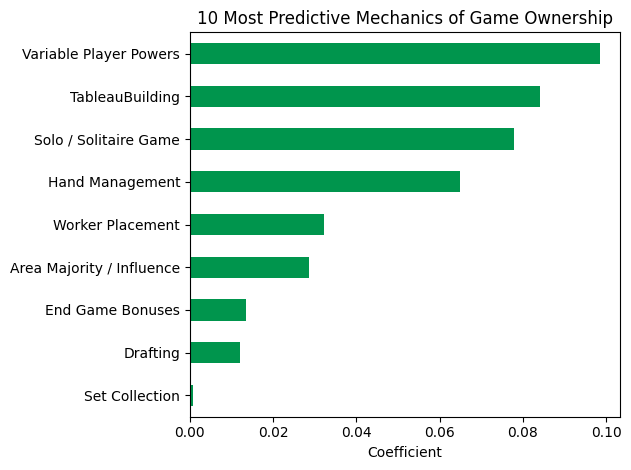

0.06798209975894332 Percent of the Variance of Game Ownership explained


In [211]:
y = mechanics_df['NumOwned_Log']
coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)

plt.figure()
coefs.sort_values().plot(kind="barh", color = "#00954d")
plt.title('10 Most Predictive Mechanics of Game Ownership')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Ownership explained")

# What are the Most Important Overall Features (Categories, Themes, and Mechanics) in a Game?

## Load and Inspect Subcategory Data

In [212]:
subcat = pd.read_csv("subcategories.csv")

print(subcat .info())
print(subcat .isnull().sum())
print(f"Duplicate BGGIds: {subcat.duplicated('BGGId').sum()}")
subcat.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   BGGId                   21925 non-null  int64
 1   Exploration             21925 non-null  int64
 2   Miniatures              21925 non-null  int64
 3   Territory Building      21925 non-null  int64
 4   Card Game               21925 non-null  int64
 5   Educational             21925 non-null  int64
 6   Puzzle                  21925 non-null  int64
 7   Collectible Components  21925 non-null  int64
 8   Word Game               21925 non-null  int64
 9   Print & Play            21925 non-null  int64
 10  Electronic              21925 non-null  int64
dtypes: int64(11)
memory usage: 1.8 MB
None
BGGId                     0
Exploration               0
Miniatures                0
Territory Building        0
Card Game                 0
Educational               0
Puzzle          

(21925, 11)

### Generate Overall Dataset

In [213]:
overall_df = cat_df.rename(columns={col: col.replace("Cat:", "") for col in cat_cols}).merge(subcat, on ='BGGId',how = 'left').merge(themes, on ='BGGId',how = 'left').merge(mechanics, on ='BGGId',how = 'left')
overall_df.index = cat_df.index
overall_df.head()

,BGGId,AvgRating,NumOwned_Log,Thematic,Strategy,War,Family,CGS,Abstract,Party,...,Contracts,Passed Action Token,King of the Hill,Action Retrieval,Force Commitment,Rondel,Automatic Resource Growth,Legacy Game,Dexterity,Physical
Name,,,,,,,,,,,,,,,,,,,,,
Die Macher,1,7.61428,8.922525,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dragonmaster,2,6.64537,7.159292,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Samurai,3,7.45601,9.653679,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tal der Könige,4,6.60006,6.459904,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acquire,5,7.33861,10.074748,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
cat_df.head()

,BGGId,AvgRating,NumOwned_Log,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
Name,,,,,,,,,,,
Die Macher,1,7.61428,8.922525,0,1,0,0,0,0,0,0
Dragonmaster,2,6.64537,7.159292,0,1,0,0,0,0,0,0
Samurai,3,7.45601,9.653679,0,1,0,0,0,0,0,0
Tal der Könige,4,6.60006,6.459904,0,0,0,0,0,0,0,0
Acquire,5,7.33861,10.074748,0,1,0,0,0,0,0,0


### Most Predictive Features of Game Rating

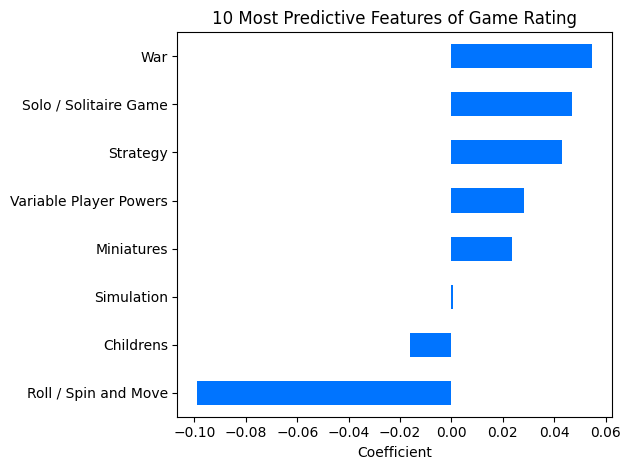

0.12084338239839332 Percent of the Variance of Game Rating explained


In [215]:
X = overall_df.drop(columns=["BGGId", "AvgRating", "NumOwned_Log"]).astype(float)
y = overall_df['AvgRating']

coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)
plt.figure()
coefs.sort_values().plot(kind="barh", color = '#0074ff')
plt.title('10 Most Predictive Features of Game Rating')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Rating explained")

### Most Predictive Features of Game Ownership

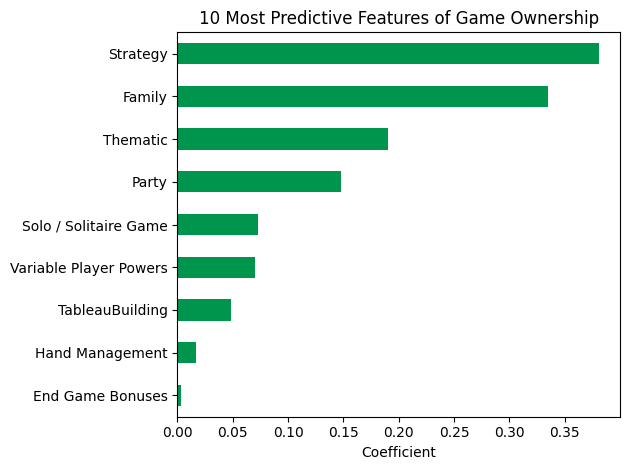

0.32409571124403225 Percent of the Variance of Game Ownership explained


In [216]:
y = overall_df['NumOwned_Log']
coefs, r2, rmse, alpha = lasso_select_top_n(X, y, top_n=10)

plt.figure()
coefs.sort_values().plot(kind="barh", color = "#00954d")
plt.title('10 Most Predictive Features of Game Ownership')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()
print(r2, "Percent of the Variance of Game Ownership explained")

### Repeat with XGBoost

### Most Important Predictors of Game Rating According to XGBoost

[I 2025-08-14 15:25:00,311] A new study created in memory with name: no-name-5e8e0357-a277-4eac-b3aa-4638939e9f4c
[I 2025-08-14 15:25:01,536] Trial 0 finished with value: 0.35181051364850513 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.17251331175978696, 'subsample': 0.7156004173397186, 'colsample_bytree': 0.6822546111320191, 'gamma': 3.9225810757772503, 'reg_lambda': 4.256096234557233}. Best is trial 0 with value: 0.35181051364850513.
[I 2025-08-14 15:25:02,636] Trial 1 finished with value: 0.3206250709269317 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.1191408906554521, 'subsample': 0.7179997762782526, 'colsample_bytree': 0.837669762268191, 'gamma': 3.0078368486614107, 'reg_lambda': 5.483243994942485}. Best is trial 0 with value: 0.35181051364850513.
[I 2025-08-14 15:25:03,850] Trial 2 finished with value: 0.3167674936964242 and parameters: {'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.04519501113989621, 'subsample': 0.

Best Parameters:
{'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.13634533353061953, 'subsample': 0.6030758856589653, 'colsample_bytree': 0.9462020480358695, 'gamma': 0.5267979072285698, 'reg_lambda': 5.145931949009456}


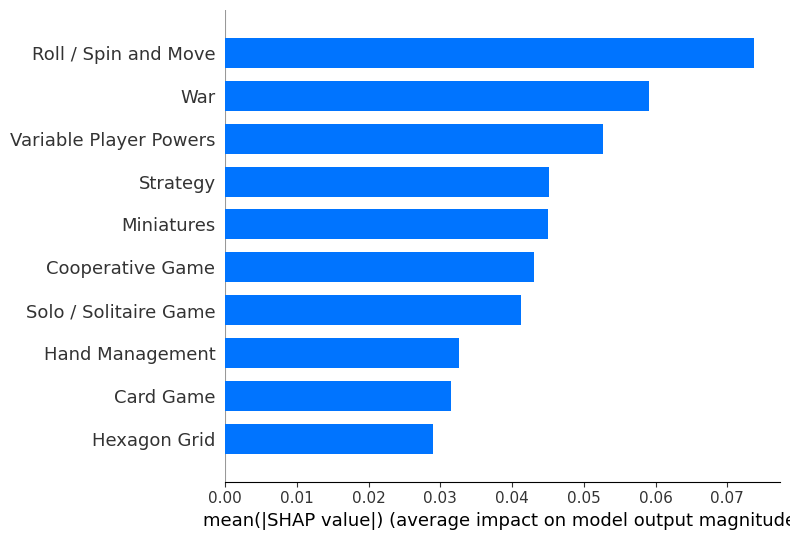

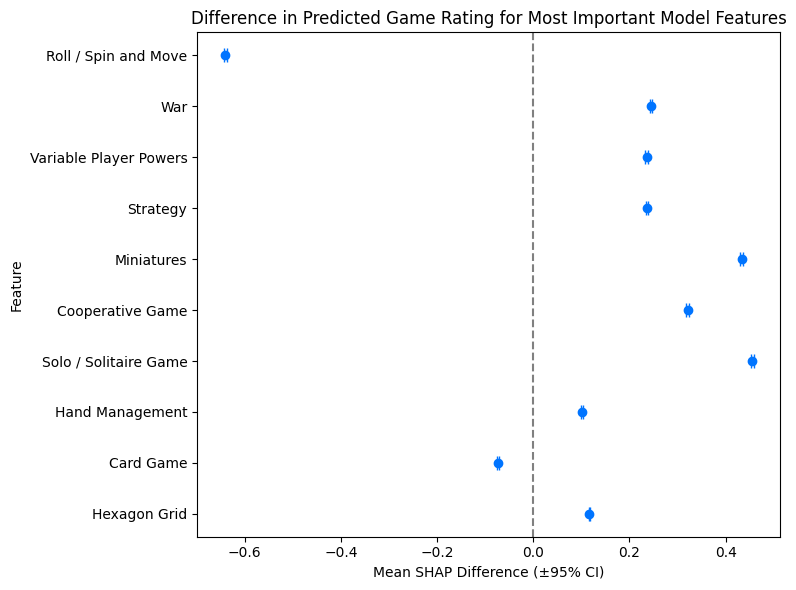

Percent of the Variance of AvgRating Explained: 0.398


In [217]:
y = overall_df['AvgRating']

model, params, r2, rmse = xgb_cv(
    X, y, plot_title='Difference in Predicted Game Rating for Most Important Model Features', plot_color= '#0074ff'
)



### Most Important Predictors of Game Ownership According to XGBoost

[I 2025-08-14 15:26:14,256] A new study created in memory with name: no-name-879f978b-5ca7-4d3a-8fac-5e41fa80320f
[I 2025-08-14 15:26:15,229] Trial 0 finished with value: 0.48523016144571224 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.11356722158228247, 'subsample': 0.641787165813109, 'colsample_bytree': 0.8577494688966112, 'gamma': 1.0276552348420824, 'reg_lambda': 6.261697068568027}. Best is trial 0 with value: 0.48523016144571224.
[I 2025-08-14 15:26:16,786] Trial 1 finished with value: 0.4973277783820723 and parameters: {'n_estimators': 122, 'max_depth': 8, 'learning_rate': 0.10316433300900836, 'subsample': 0.6155928900365476, 'colsample_bytree': 0.9940447025318269, 'gamma': 0.5873964636409035, 'reg_lambda': 6.236838965831904}. Best is trial 1 with value: 0.4973277783820723.
[I 2025-08-14 15:26:17,792] Trial 2 finished with value: 0.492579965245371 and parameters: {'n_estimators': 93, 'max_depth': 7, 'learning_rate': 0.13913957719333636, 'subsample': 0.8

Best Parameters:
{'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.13513839372677308, 'subsample': 0.6775796572990458, 'colsample_bytree': 0.9619536828691558, 'gamma': 0.43157509150978124, 'reg_lambda': 1.9237639319026165}


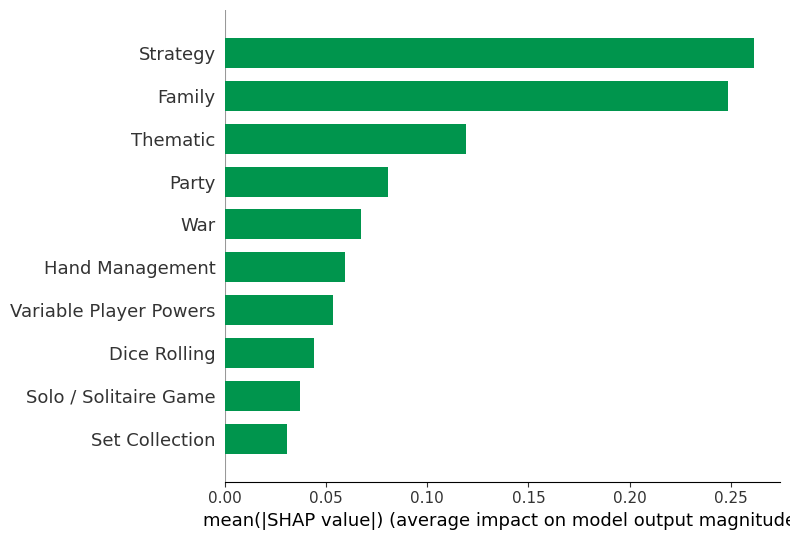

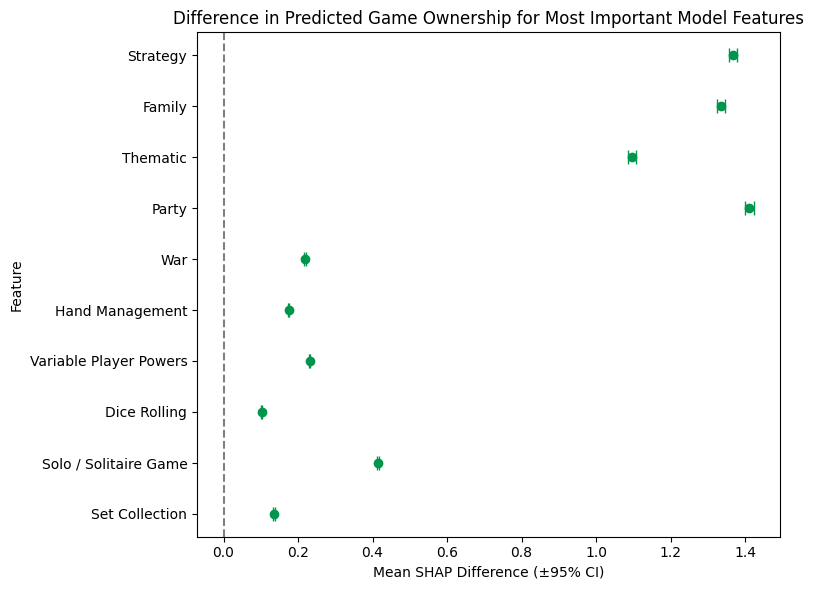

Percent of the Variance of NumOwned_Log Explained: 0.489


In [218]:
y = overall_df['NumOwned_Log']

model, params, r2, rmse = xgb_cv(
    X, y, plot_title='Difference in Predicted Game Ownership for Most Important Model Features', plot_color="#00954d"
)

# What are the Best and Worst Kinds of Game?

## Determine Number of Groups to Extract

c:\Users\natha\Dropbox\Projects\BGG\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\natha\Dropbox\Projects\BGG\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


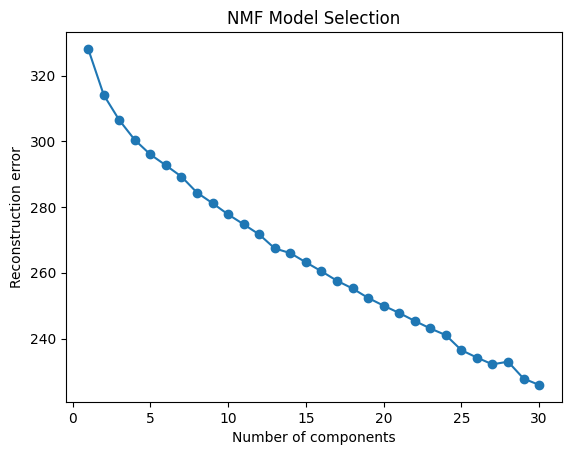

In [219]:
overall_NMF = overall_df.drop(columns=["BGGId", "AvgRating", "NumOwned_Log"])

error = []
for k in range(1, 31):
    nmf_model = NMF(n_components=k, init="nndsvd", random_state=123)
    nmf_fit = nmf_model.fit_transform(overall_NMF)
    error.append(nmf_model.reconstruction_err_)

plt.figure()
plt.plot(range(1, 31), error, "-o")
plt.xlabel("Number of components")
plt.ylabel("Reconstruction error")
plt.title("NMF Model Selection")
plt.show()

## Extract 10 Components

In [220]:
n_components = 10
nmf = NMF(n_components=n_components, init="nndsvd", random_state=123)
W = nmf.fit_transform(overall_NMF)
H = pd.DataFrame(nmf.components_, columns=overall_NMF.columns)

Component_Names = ["Card","War","Thematic/Co-op", "Strategy/Management", "Luck-Based", 'Pattern/Puzzle', "Social Deduction","Family/Children","Trading/Negotiation","Fantasy/Adventure"]

top_features = H.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
for i, features in enumerate(top_features):
    clean_names = [f.replace("Cat:", "") for f in features]
    print(f"{Component_Names[i]}: {', '.join(clean_names)}")
    


Card: Card Game, Hand Management, Drafting, Take That, Humor
War: War, Hexagon Grid, Simulation, World War II, Grid Movement
Thematic/Co-op: Variable Player Powers, Fighting, Science Fiction, Modular Board, Thematic
Strategy/Management: Strategy, Economic, Area Majority / Influence, Auction/Bidding, Worker Placement
Luck-Based: Dice Rolling, Push Your Luck, Roll / Spin and Move, Area Movement, Paper-and-Pencil
Pattern/Puzzle: Tile Placement, Abstract, Modular Board, Pattern Building, Puzzle
Social Deduction: Betting and Bluffing, Deduction, Memory, Team-Based Game, Party
Family/Children: Family, Animals, Dexterity, Childrens, Push Your Luck
Trading/Negotiation: Set Collection, Drafting, Roll / Spin and Move, Auction/Bidding, Trading
Fantasy/Adventure: Fantasy, Adventure, Fighting, Medieval, Exploration


### Which Components are Rated Highest?

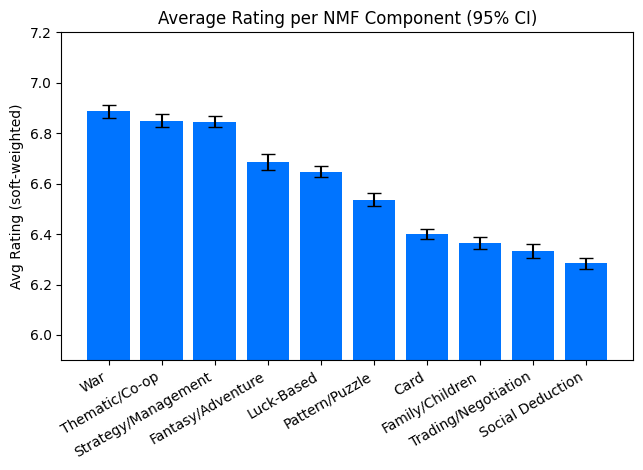

In [221]:
y = overall_df["AvgRating"].values

boot_means = bootstrap_soft_averages(W, y)

lower = np.percentile(boot_means, 2.5, axis=0)
upper = np.percentile(boot_means, 97.5, axis=0)
mean = np.mean(boot_means, axis=0)

nmf_stats = pd.DataFrame({
    "Component": np.arange(n_components),
    "MeanRating": mean,
    "CI_Lower": lower,
    "CI_Upper": upper
})

nmf_stats = nmf_stats.sort_values("MeanRating", ascending=False)
order_by_rating = nmf_stats["Component"].tolist()
pos = np.arange(len(nmf_stats))

plt.figure()
plt.bar(
    pos,
    nmf_stats["MeanRating"],
    yerr=[
        nmf_stats["MeanRating"] - nmf_stats["CI_Lower"],
        nmf_stats["CI_Upper"] - nmf_stats["MeanRating"]
    ],
    capsize=5, 
    color = '#0074ff'
)
sorted_names = [Component_Names[i] for i in nmf_stats["Component"]]
plt.xticks(pos, sorted_names, rotation=30, ha='right')
plt.ylabel("Avg Rating (soft-weighted)")
plt.title("Average Rating per NMF Component (95% CI)")
plt.tight_layout()
plt.ylim(5.9,7.2)
plt.show()


### Which Components are Most Owned?

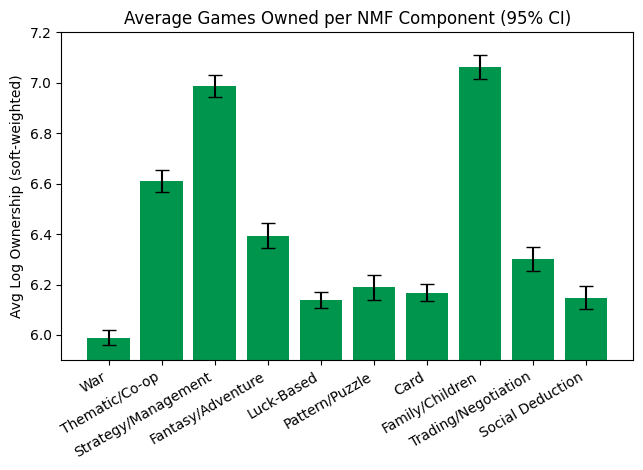

In [222]:
y = overall_df["NumOwned_Log"].values

boot_means = bootstrap_soft_averages(W, y)

lower = np.percentile(boot_means, 2.5, axis=0)
upper = np.percentile(boot_means, 97.5, axis=0)
mean = np.mean(boot_means, axis=0)

nmf_stats = pd.DataFrame({
    "Component": np.arange(n_components),
    "MeanRating": mean,
    "CI_Lower": lower,
    "CI_Upper": upper
})

nmf_stats = (
    nmf_stats.set_index("Component")
                   .loc[order_by_rating]
                   .reset_index()
)
pos = np.arange(len(nmf_stats))

plt.figure()
plt.bar(
    pos,
    nmf_stats["MeanRating"],
    yerr=[
        nmf_stats["MeanRating"] - nmf_stats["CI_Lower"],
        nmf_stats["CI_Upper"] - nmf_stats["MeanRating"]
    ],
    capsize=5, 
    color = "#00954d"
)
sorted_names = [Component_Names[i] for i in nmf_stats["Component"]]
plt.xticks(pos, sorted_names, rotation=30, ha='right')
plt.ylabel("Avg Log Ownership (soft-weighted)")
plt.title("Average Games Owned per NMF Component (95% CI)")
plt.tight_layout()
plt.ylim(5.9,7.2)
plt.show()

# Board Game Recommendation

## Content based recommendation using Cosine Similarity

In [223]:
def recommend_similar_games(game_name, top_n=10):
    """
    Recommends the most similar games to a given game name using overall_df.

    Parameters:
    - game_name: The name of the game to find similar games for.
    - top_n: Number of recommendations to return.

    Returns:
    - pd.DataFrame: Top N most similar games.
    """
    features = overall_df.drop(columns=['BGGId'])
    
    scaler = StandardScaler()
    features[["AvgRating", "NumOwned_Log"]] = scaler.fit_transform(features[["AvgRating", "NumOwned_Log"]])

    if game_name not in overall_df.index:
        raise ValueError(f"Game '{game_name}' not found in dataset.")

    target_vector = features[overall_df.index == game_name].values
    if target_vector.shape[0] == 0:
        raise ValueError(f"No data found for '{game_name}'.")

    similarities = cosine_similarity(target_vector, features)[0]

    df_result = overall_df.copy()
    df_result["Similarity"] = similarities
    recommendations = (
        df_result[df_result.index != game_name]
        .sort_values("Similarity", ascending=False)
        .head(top_n)
    )

    return recommendations[["AvgRating", "NumOwned_Log", "Similarity"]]

print(f"Games similar to 'Settlers of Catan':\n{recommend_similar_games("Catan", top_n=10)}")
print(f"Games similar to 'Apples to Apples':\n{recommend_similar_games("Apples to Apples", top_n=10)}")

Games similar to 'Settlers of Catan':
                   AvgRating  NumOwned_Log  Similarity
Name                                                  
Istanbul             7.57049     10.375084    0.822013
Star Trek: Catan     7.00475      9.071423    0.768060
Vault of Dragons     6.61322      6.801283    0.767515
Can't Stop           6.85195      9.468310    0.756595
Bananagrams Party    6.42847      6.242223    0.756184
Las Vegas            7.13381      9.408863    0.752956
Machi Koro           6.62445     10.701850    0.752852
Power Grid           7.84328     11.151425    0.748894
Captive              6.85869      7.280008    0.743801
Stone Age            7.55670     10.818958    0.743021
Games similar to 'Apples to Apples':
                        AvgRating  NumOwned_Log  Similarity
Name                                                       
Cards Against Humanity    5.86902     10.645520    0.946596
Joking Hazard             6.37218      9.341456    0.908168
Unstable Unicorns        